In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from test_tools import generate_objects, BunchTracker, track, compare_traces, compare_projections, Machine

from PyHEADTAIL_feedback.feedback import OneboxFeedback, PickUp, Kicker
from PyHEADTAIL_feedback.processors import Bypass
from PyHEADTAIL_feedback.processors import CosineSumRegister, VectorSumRegister
from PyHEADTAIL_feedback.digital_processors import HilbertPhaseShiftRegister

np.random.seed(0)

PyHEADTAIL v1.9.4




In [2]:
#Generater bunch slicer and maps. See the code for generator in the file test_tools.py 

n_macroparticles = 1000
n_slices = 20
n_segments = 5
n_sigma_z = 3 

feedback_gain = 0.01
n_turns = 300

bunch_ref, slicer_ref,trans_map, long_map = generate_objects(n_macroparticles,n_segments, n_slices,n_sigma_z)

machine = Machine() # machine parameters

xp_per_x = bunch_ref.sigma_xp()/bunch_ref.sigma_x()
yp_per_y = bunch_ref.sigma_yp()/bunch_ref.sigma_y()

In [3]:


slice_set = bunch_ref.get_slices(slicer_ref, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

#random kicks
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]
    
bunch_init = copy.deepcopy(bunch_ref)
tracker_ref = BunchTracker(bunch_init)
maps_ref = [i for i in trans_map] + [long_map]
track(n_turns, bunch_init,maps_ref,tracker_ref)

In [4]:
# Register parameters
delay = 1
n_avg = 9

n_pickups = 3

kicker_pos = 2

In [5]:
bunch_OneBox = copy.deepcopy(bunch_ref)
tracker_OneBox = BunchTracker(bunch_OneBox)
slicer_OneBox = copy.deepcopy(slicer_ref)

# signal processor chains
signal_processors_x = [Bypass()]
signal_processors_y = [Bypass()]

feedback_map = OneboxFeedback(feedback_gain,slicer_OneBox,signal_processors_x,signal_processors_y)
total_map_OneBox = [i for i in trans_map] + [long_map] + [feedback_map]
track(n_turns, bunch_OneBox,total_map_OneBox,tracker_OneBox)

In [6]:
bunch_FIR = copy.deepcopy(bunch_ref)
tracker_FIR = BunchTracker(bunch_FIR)
slicer_FIR = copy.deepcopy(slicer_ref)

# signal processor chains
FIR_x_pickups = []
FIR_y_pickups = []
FIR_x_pickup_list = []
FIR_y_pickup_list = []

pickup_maps = []
for i in xrange(n_pickups):
    FIR_x_pickups.append([HilbertPhaseShiftRegister(n_avg, machine.Q_x, delay)])
    FIR_y_pickups.append([HilbertPhaseShiftRegister(n_avg, machine.Q_y, delay)])
    pickup_maps += [PickUp(slicer_FIR,FIR_x_pickups[i],FIR_y_pickups[i], 
                         float(i)*2.*pi/float(n_segments)*machine.Q_x, float(i)*2.*pi/float(n_segments)*machine.Q_y)]

    FIR_x_pickup_list.append(FIR_x_pickups[i][0])
    FIR_y_pickup_list.append(FIR_y_pickups[i][0])
    
FIR_x_kicker = [Bypass()]
FIR_y_kicker = [Bypass()]

kicker_map = Kicker(feedback_gain,slicer_FIR,FIR_x_kicker,FIR_y_kicker, 
                    float(kicker_pos)*2.*pi/float(n_segments)*machine.Q_x, float(kicker_pos)*2.*pi/float(n_segments)*machine.Q_y,
                    FIR_x_pickup_list,FIR_y_pickup_list, xp_per_x, yp_per_y)
total_map_FIR = []
for i, element in enumerate(trans_map):
    if i < n_pickups:
        total_map_FIR += [pickup_maps[i]]
    if i == kicker_pos:
        total_map_FIR += [kicker_map]
    total_map_FIR += [element]

track(n_turns, bunch_FIR,total_map_FIR,tracker_FIR)

In [7]:
bunch_cosine = copy.deepcopy(bunch_ref)
tracker_cosine = BunchTracker(bunch_cosine)
slicer_cosine = copy.deepcopy(slicer_ref)

# signal processor chains
cosine_x_pickups = []
cosine_y_pickups = []
cosine_x_pickup_list = []
cosine_y_pickup_list = []

pickup_maps = []
for i in xrange(n_pickups):
    cosine_x_pickups.append([CosineSumRegister(n_avg, machine.Q_x, delay)])
    cosine_y_pickups.append([CosineSumRegister(n_avg, machine.Q_y, delay)])
    pickup_maps += [PickUp(slicer_cosine,cosine_x_pickups[i],cosine_y_pickups[i], 
                         float(i)*2.*pi/float(n_segments)*machine.Q_x, float(i)*2.*pi/float(n_segments)*machine.Q_y)]

    cosine_x_pickup_list.append(cosine_x_pickups[i][0])
    cosine_y_pickup_list.append(cosine_y_pickups[i][0])
    
cosine_x_kicker = [Bypass()]
cosine_y_kicker = [Bypass()]

kicker_map = Kicker(feedback_gain,slicer_cosine,cosine_x_kicker,cosine_y_kicker, 
                    float(kicker_pos)*2.*pi/float(n_segments)*machine.Q_x, float(kicker_pos)*2.*pi/float(n_segments)*machine.Q_y,
                    cosine_x_pickup_list,cosine_y_pickup_list, xp_per_x, yp_per_y)
total_map_cosine = []
for i, element in enumerate(trans_map):
    if i < n_pickups:
        total_map_cosine += [pickup_maps[i]]
    if i == kicker_pos:
        total_map_cosine += [kicker_map]
    total_map_cosine += [element]

total_map_cosine += [long_map]

track(n_turns, bunch_cosine,total_map_cosine,tracker_cosine)

In [8]:
bunch_vector = copy.deepcopy(bunch_ref)
tracker_vector = BunchTracker(bunch_vector)
slicer_vector = copy.deepcopy(slicer_ref)

# signal processor chains
vector_x_pickups = []
vector_y_pickups = []
vector_x_pickup_list = []
vector_y_pickup_list = []

pickup_maps = []
for i in xrange(n_pickups):
    vector_x_pickups.append([VectorSumRegister(n_avg, machine.Q_x, delay)])
    vector_y_pickups.append([VectorSumRegister(n_avg, machine.Q_y, delay)])
    pickup_maps += [PickUp(slicer_vector,vector_x_pickups[i],vector_y_pickups[i], 
                         float(i)*2.*pi/float(n_segments)*machine.Q_x, float(i)*2.*pi/float(n_segments)*machine.Q_y)]

    vector_x_pickup_list.append(vector_x_pickups[i][0])
    vector_y_pickup_list.append(vector_y_pickups[i][0])
    
vector_x_kicker = [Bypass()]
vector_y_kicker = [Bypass()]

kicker_map = Kicker(feedback_gain,slicer_vector,vector_x_kicker,vector_y_kicker, 
                    float(kicker_pos)*2.*pi/float(n_segments)*machine.Q_x, float(kicker_pos)*2.*pi/float(n_segments)*machine.Q_y,
                    vector_x_pickup_list,vector_y_pickup_list, xp_per_x, yp_per_y)
total_map_vector = []
for i, element in enumerate(trans_map):
    if i < n_pickups:
        total_map_vector += [pickup_maps[i]]
    if i == kicker_pos:
        total_map_vector += [kicker_map]
    total_map_vector += [element]

track(n_turns, bunch_vector,total_map_vector,tracker_vector)

Delta phi: 259.2
Delta phi: 248.4
Delta phi: 259.2
Delta phi: 248.4
Delta phi: 259.2
Delta phi: 248.4
Delta phi: 131.657142857
Delta phi: 34.9714285714
Delta phi: 34.9714285714
Delta phi: 340.457142857
Delta phi: 301.371428571
Delta phi: 301.371428571
Delta phi: 259.2
Delta phi: 259.2
Delta phi: 248.4
Delta phi: 248.4
Delta phi: 259.2
Delta phi: 259.2
Delta phi: 248.4
Delta phi: 248.4
Delta phi: 259.2
Delta phi: 259.2
Delta phi: 248.4
Delta phi: 248.4
Delta phi: 131.657142857
Delta phi: 131.657142857
Delta phi: 34.9714285714
Delta phi: 34.9714285714
Delta phi: 34.9714285714
Delta phi: 34.9714285714
Delta phi: 340.457142857
Delta phi: 340.457142857
Delta phi: 301.371428571
Delta phi: 301.371428571
Delta phi: 301.371428571
Delta phi: 301.371428571
Delta phi: 259.2
Delta phi: 259.2
Delta phi: 259.2
Delta phi: 248.4
Delta phi: 248.4
Delta phi: 248.4
Delta phi: 259.2
Delta phi: 259.2
Delta phi: 259.2
Delta phi: 248.4
Delta phi: 248.4
Delta phi: 248.4
Delta phi: 259.2
Delta phi: 259.2
Delta 

In [9]:
# bunch_add = copy.deepcopy(bunch_ref)
# tracker_add = BunchTracker(bunch_add)
# slicer_add = copy.deepcopy(slicer_ref)

# # signal processor chains
# processors_add_x = [BypassAddition()]
# processors_add_y = [BypassAddition()]

# feedback_map = OneboxFeedback(feedback_gain,slicer_add,processors_add_x,processors_add_y)
# total_map_add = [i for i in trans_map] + [long_map] + [feedback_map]

# track(n_turns, bunch_add,total_map_add,tracker_add)

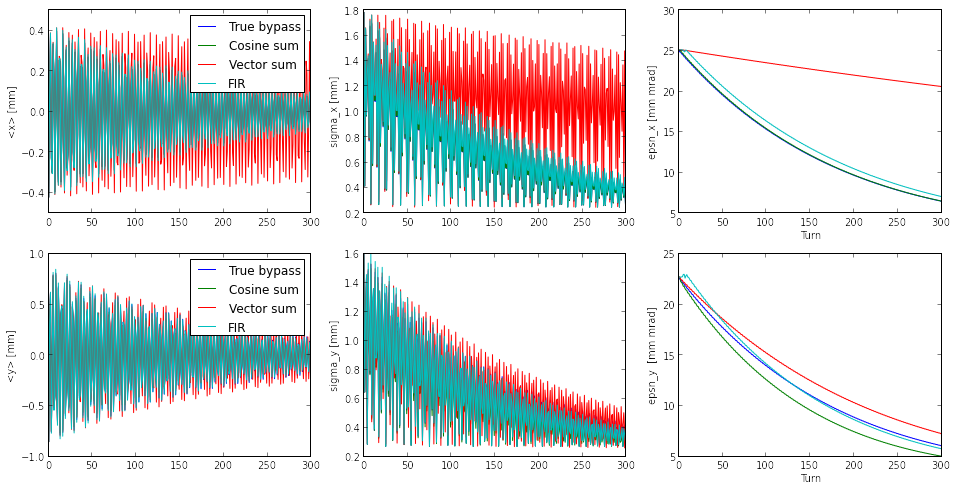

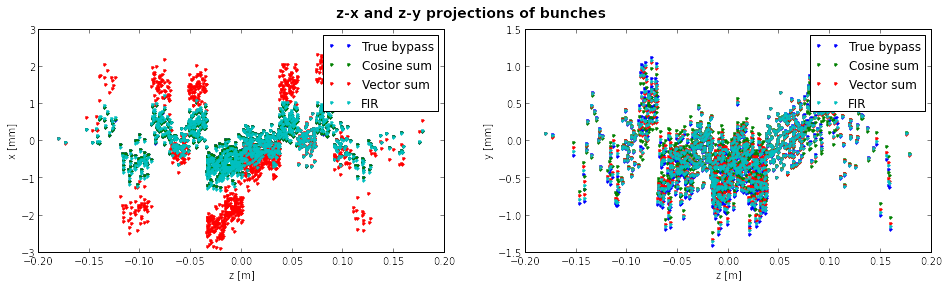

In [10]:
compare_traces([tracker_OneBox,tracker_cosine,tracker_vector,tracker_FIR],
               ['True bypass','Cosine sum','Vector sum','FIR'])
compare_projections([bunch_OneBox,bunch_cosine,bunch_vector,bunch_FIR], 
               ['True bypass','Cosine sum','Vector sum','FIR'])

In [11]:
# multiple pick-ups and kickers